# Amazon Fine Food Reviews - G2T5

## 1. Read the dataframe and perform data cleaning

In [1]:
import pandas as pd

In [2]:
# Read the csv file
df = pd.read_csv('Reviews.csv')

In [3]:
# Removing duplicate rows 
# Checking duplicates based on UserId, ProfileName, Time, Text. If all these values are equal then we will remove those records. 
df = df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

In [4]:
# HelpfulnessNumerator: Number of users who found the review helpful
# HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not

# Keep records with HelpfulnessNumerator less than or equal to HelpfulnessDenominator 
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
df.shape

(393931, 10)

## 2. Take a random sample of 80,000 reviews

We will be using a sample of 80,000 reviews and then perform clustering on them.

In [5]:
# taking a sample of 80k reviews randomly
new_df = df.sample(80000)

In [6]:
# # Save the new_df
# import pickle

# save_classifier = open("new_df.pickle","wb")
# pickle.dump(new_df, save_classifier)
# save_classifier.close()

In [9]:
# Retrieve the new_df
import pickle

classifier_saved = open("new_df.pickle",'rb')
new_df = pickle.load(classifier_saved)
classifier_saved.close()

In [10]:
new_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
144798,144799,B000HQNE2S,A920YQSKVECLQ,"Ontos Crewman ""0311 0353""",0,0,5,1298073600,Food Critics Abound,This is a quick and easy instant soup mix that...
17529,17530,B0045Z6K50,A3FIBMRACIHDVR,"Julie Waters ""D.M. Waters""",0,0,5,1339718400,Great Coffee,Newmans makes really good coffee. This seems t...
529825,529826,B004T88BYQ,A2X5FVCH08OGL7,Quant,0,0,3,1343433600,Like the taste... too bad prices rose 10%+ las...,Pros:<br /><br />These cereal taste good. At $...
382654,382655,B004VLVLQQ,A3KL0DWTREYA7N,"Mike BonDURANT ""MUSEUMMUSCLE""",2,2,5,1332892800,Great Bread!,My wife uses this mix for our everyday bread. ...
508891,508892,B0063HW066,A3ELY490R6CEKW,Dan-0,0,1,5,1342310400,Good Product,Was scared to try it because of its color and ...


In [11]:
# Read the Text, Id, and ProductId column and store it into a list 
Text = new_df['Text']
Text_list = list(Text)

Id = new_df['Id'] 
Id_list = list(Id)

ProductId = new_df['ProductId'] 
ProductId_list = list(ProductId)

# Create a dictionary with ID as the key and Text and ProductId as the values
Text_dict = dict(zip(Id_list, Text_list)) 
ProductId_dict = dict(zip(Id_list, ProductId_list)) 

## 3. Preprocess the 80,000 reviews

1. Convert all the words to lowercase, keep only alphabetic characters, and remove stopwords
2. Create a new list (proper_nouns) to store all the nouns
3. Lemmatizating the proper_nouns
4. Remove the top 150 common words and single letter words
5. Remove empty list/reviews after preprocessing is done

In [ ]:
# Preprocess the data
# Convert all to lower cases, keep only alphabetic chars, remove stop words
# Create a new list (proper_nouns) to store all the nouns

import nltk
from nltk.tokenize import word_tokenize
import re
stop_list = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.porter.PorterStemmer()

proper_nouns = []

for review in Text_list:
    doc = review.split()
    doc1 = [w.lower() for w in doc]
    doc2 = [w for w in doc1 if re.search('^[a-z]+$', w)]
    doc3 = [w for w in doc2 if w not in stop_list]

    tagsText= nltk.pos_tag(doc3)

    propernouns = [word for word,pos in tagsText if pos in ['NN','NNS','NNP','NNPS']]
    proper_nouns.append(propernouns)
print(proper_nouns)
        

In [12]:
# # Save the proper_nouns
# import pickle

# save_classifier = open("proper_nouns.pickle","wb")
# pickle.dump(proper_nouns, save_classifier)
# save_classifier.close()

In [14]:
# Retrieve the proper_nouns
import pickle

classifier_saved = open("proper_nouns.pickle",'rb')
proper_nouns = pickle.load(classifier_saved)
classifier_saved.close()

In [15]:
# Lemmatizating the proper nouns (output: nouns_lem)
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nouns_lem =[]
for doc in proper_nouns:
    nouns_lem.append([lemmatizer.lemmatize(w) for w in doc])
    

In [16]:
# Placing all the lemmatized proper nouns into one complied list
compiled_list = []
for doc in nouns_lem:
    for w in doc:
        compiled_list.append(w)

In [17]:
# Retrieve the top 150 most common words
import nltk
fdist = nltk.FreqDist(compiled_list)
most_common = fdist.most_common(150)
# print(most_common)

In [18]:
# Retrieve only the top 150 words, without the frequency
only_common_words =[]
for word,num in most_common:
    only_common_words.append(word)

In [19]:
# Removing the top 150 common words from only_common_words and single letters, eg: "k"
compiled_list = []
for doc in nouns_lem:
    uncommon_words_list = []
    for w in doc:
        if w not in only_common_words and len(w) > 1:
            uncommon_words_list.append(w)
            
    compiled_list.append(uncommon_words_list)

In [20]:
# Create a list to store the ids with empty lists after preprocessing

id_to_remove = []
for i in range(len(compiled_list)):
    if len(compiled_list[i]) == 0:
        id_to_remove.append(Id_list[i])

In [21]:
# Update the dictionaries created earlier to remove the ids with empty list
for i in id_to_remove:
    del Text_dict[i]
    del ProductId_dict[i]


In [22]:
# Create a list to store the reviews after removing empty lists
# The number of reviews remaining for clustering is 75,942
compiled_list = [x for x in compiled_list if x != []]
#print(compiled_list)
#print(len(compiled_list))

In [23]:
# Create a list to store the ID, Text, and ProductId after removing empty lists
Id_list_final = list(Text_dict.keys())

Text_list_final = list(Text_dict.values())

ProductId_list_final = list(ProductId_dict.values())

## 4. Perform Elbow Method to retrieve the optimal number of clusters

In [24]:
# Join all the nouns back into a sentence for each review 
proper_nouns_joined = []
for propernouns in compiled_list:
    propernouns = ' '.join(propernouns)
    proper_nouns_joined.append(propernouns)
    
# print(proper_nouns_joined)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=1500)
bow = tfidf_vec.fit_transform(proper_nouns_joined)
bow.shape

(75942, 1500)

In [ ]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
clusters_list = [2,10,20,30,40,50,60,70,80,90,100]
wcss = []
for i in clusters_list:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(bow)
    wcss.append(kmeans.inertia_)

In [26]:
clusters_list = [2,10,20,30,40,50,60,70,80,90,100]

# Retrieve wcss (sum of the squared distance between each member of the cluster and its centroid)
import pickle

classifier_saved = open("wcss.pickle",'rb')
wcss = pickle.load(classifier_saved)
classifier_saved.close()

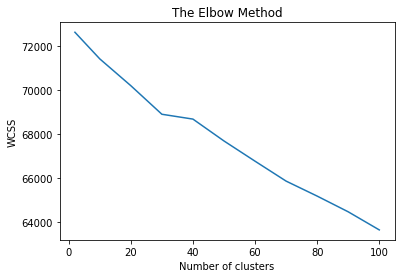

In [28]:
# Plot the graph out
# We have identified 30 to be the optimal number of clusters
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(clusters_list, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
# # Save the clusters
# import pickle

# save_classifier = open("wcss.pickle","wb")
# pickle.dump(wcss, save_classifier)
# save_classifier.close()

## 5. Perform K-Means Clustering 

In [30]:
import gensim
dictionary = gensim.corpora.Dictionary(compiled_list)

C:\Users\denys\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [31]:
# Transform the documents into TF-IDF-based document vectors
vecs1 = [dictionary.doc2bow(doc) for doc in compiled_list]
tfidf = gensim.models.TfidfModel(vecs1)
vecs = [tfidf[vec] for vec in vecs1]
# vecs

In [28]:
# Perform K-means clustering with 30 clusters
import k_means

num_tokens = len(dictionary.token2id)
clusters = k_means.k_means(vecs, num_tokens, 30)

In [29]:
# # Save the clusters
# import pickle

# save_classifier = open("clusters_30.pickle","wb")
# pickle.dump(clusters, save_classifier)
# save_classifier.close()

In [32]:
# Retrieve the clusters
import pickle

classifier_saved = open("clusters_30.pickle",'rb')
clusters = pickle.load(classifier_saved)
classifier_saved.close()

In [33]:
# Retrieve the words from the documents according to the cluster number
clusters_all_words = []

for i in range(0,30):
    indv_cluster_words = []
    for fid in clusters[i]:
        indv_cluster_words.extend(compiled_list[fid])
    clusters_all_words.append(indv_cluster_words)

## 6. Cluster Visualisation

In [35]:
# Display the top 10 words from each cluster
clusters_dist = []
for indv_cluster_words in clusters_all_words:

    fdist = nltk.FreqDist(indv_cluster_words)
    clusters_dist.append(fdist.most_common(10))

i = 0
for cluster in clusters_dist:
    print('Cluster ' + str(i) + ': ')
    print(cluster)
    print('')
    i += 1

Cluster 0: 
[('ginger', 601), ('date', 586), ('cake', 583), ('cookie', 549), ('daughter', 541), ('almond', 508), ('thanks', 495), ('wheat', 469), ('enjoy', 401), ('gluten', 396)]

Cluster 1: 
[('noodle', 1001), ('spicy', 885), ('pepper', 527), ('tomato', 462), ('chili', 446), ('curry', 331), ('veggie', 316), ('onion', 274), ('dish', 272), ('bowl', 207)]

Cluster 2: 
[('grind', 227), ('smooth', 194), ('grinder', 100), ('fine', 86), ('drip', 67), ('press', 58), ('marzipan', 40), ('okay', 34), ('comparison', 33), ('soooo', 32)]

Cluster 3: 
[('subscribe', 563), ('shipment', 338), ('option', 329), ('subscription', 289), ('save', 289), ('saving', 60), ('delivery', 57), ('discount', 53), ('program', 48), ('sale', 46)]

Cluster 4: 
[('supermarket', 486), ('mention', 107), ('reviewer', 20), ('shelf', 20), ('yeast', 20), ('difference', 20), ('stock', 19), ('glad', 17), ('batch', 15), ('wheat', 15)]

Cluster 5: 
[('color', 894), ('shampoo', 281), ('conditioner', 255), ('person', 220), ('matcha',

(-0.5, 399.5, 199.5, -0.5)

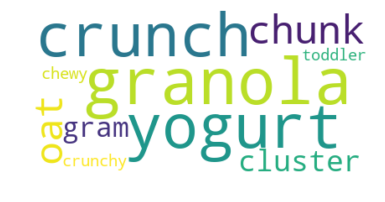

In [36]:
# Display each cluster in a word cloud
cluster_words = ''
for word, count in clusters_dist[10]:
    word_ = word + ' '
    cluster_words += word_

from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(cluster_words)

# Display the generated image:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [37]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\denys\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


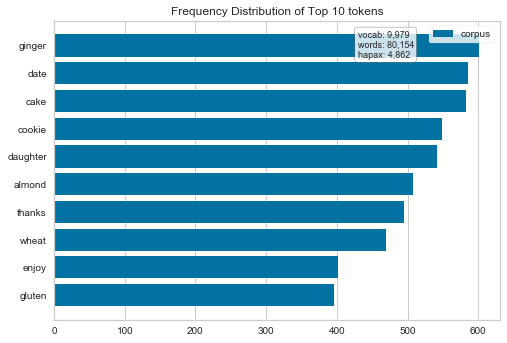

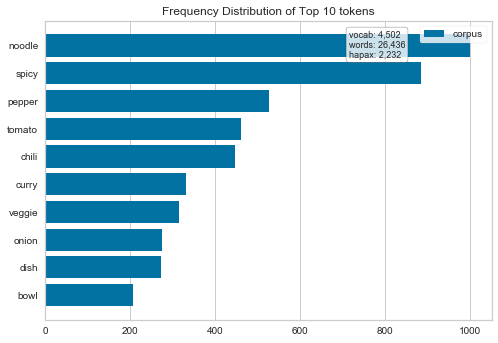

In [39]:
# Display a bar chart to show the frequency of the words for each cluster
for i in range(2):
    all_words=[]
    for fid in clusters[i]:

        per_group = ' '.join(compiled_list[fid])
        all_words.append(per_group)
        
    vectorizer = CountVectorizer()
    docs       = vectorizer.fit_transform(all_words)
    features   = vectorizer.get_feature_names()


    visualizer = FreqDistVisualizer(features=features, orient='h', n=10)
    visualizer.fit(docs)
    visualizer.show()

## 7. Retrieving top 5 most relevant documents

In [40]:
#convert all the reviews in cluster 5 into a list of sparse vectors
review_vecs = [dictionary.doc2bow(compiled_list[fid]) for fid in clusters[29]]

In [41]:
from gensim import similarities

#building the index from the list of sparse vectors

index = similarities.SparseMatrixSimilarity(review_vecs,23690) 

In [42]:
#retrieve top 30 words from cluster 5 that represents the cluster
clusters_dist = []

fdist = nltk.FreqDist(clusters_all_words[29])
clusters_dist=fdist.most_common(30)

top_words = []
for word in clusters_dist:
    top_words.append(word[0])

In [43]:
#compute cosine similarity with the top 30 words in the cluster and all thre reviews in the cluster
top_words_vec = dictionary.doc2bow(top_words)
sims = index[top_words_vec] 
sorted_sims = sorted(enumerate(sims), key = lambda item: -item[1])


In [44]:
#return the position of the top 5 most relevant reviews in the cluster
print(sorted_sims[0:5])
final_reviews = sorted_sims[0:5]

[(2460, 0.40414518), (927, 0.38729832), (464, 0.372678), (1075, 0.372678), (2126, 0.372678)]


In [45]:
top_position = [review[0] for review in final_reviews]

In [46]:
#retrieve the top 5 most relevant review id in the cluster
final =[]
for position in top_position:
    final.append(clusters[29][position])
print(final)

[58851, 22122, 11132, 25328, 50295]


In [47]:
# Display the top 5 most relevant reviews with the ID  and store it in a list
top_5_reviews = []
top_5_reviews_products = []
for i in final:
    top_5_reviews_products.append(ProductId_list_final[i])
    top_5_reviews.append(Text_list_final[i])
    print("ProductId: " + ProductId_list_final[i])
    print(Text_list_final[i])
    print("\n")

ProductId: B000JVAEPQ
Tully's Coffee "Italian Roast (Bold)" K-Cups makes a very good cup of coffee in my <a href="http://www.amazon.com/gp/product/B000AQPMHA">Keurig B-40 B40 Elite Gourmet Single-Cup Home-Brewing System</a>. This is a fairly strong tasting brew that has much more flavor than the <a href="http://www.amazon.com/gp/product/B0029XDZIK">Coffee People, Donut Shop K-Cups for Keurig Brewers (Pack of 50) [Amazon Frustration-Free Packaging</a>] I generally drink in the morning.<br /><br />I really enjoy the rich flavor of this coffee but my wife thinks it is "slightly burnt" tasting. It is not as "bold" as <a href="http://www.amazon.com/gp/product/B001D0IZBM">Emeril's Big Easy Bold Coffee for Keurig Brewers, 24-Count K-Cups (Pack of 2)</a> when made on the machine's "large" cup setting.<br /><br />Recommended!<br /><br />CFH


ProductId: B007OXJL0G
These Green Mountain "Caramel Vanilla Cream" K-Cups make good tasting coffee, with noticeable but not overpowering caramel and vanil

## 8. Document Insertion

We mainly used wordnets from sklearn to perform the document insertion. Our rationale was to compare the semantics of each word of the new review with the top 30 words from each cluster. We then summed the similarity score to derive the highest scoring cluster. We determined that this was the cluster that the review belonged to.

In [48]:
import string
from string import digits
from sklearn import preprocessing
import itertools

import scipy
import re, nltk
from nltk.corpus import wordnet as wn
nltk.download('punkt')
import itertools
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The review below was randomly picked from our original dataset and is not in the sample of the datatset we took initially.

In [49]:
inserted_text = "This is the best berry pie out there for me, the texture is amazing, its super crunchy. I love the cranberry pastry from this brand too but I cannot find it in markets anymore. Thank god I found it on Amazon. "

In [50]:
# Peform text preprocessing 

import nltk
from nltk.tokenize import word_tokenize
import re
stop_list = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.porter.PorterStemmer()

inserted_text_nouns = []
# PlaintextCorpusReader automatically tokenize the words when reading the text
for w in inserted_text.split():
    doc1 = [w.lower()]
    doc2 = [w for w in doc1 if re.search('^[a-z]+$', w)]
    doc3 = [w for w in doc2 if w not in stop_list]

    tagsText= nltk.pos_tag(doc3)

    
    propernouns = [word for word,pos in tagsText if pos in ['NN','NNS','NNP','NNPS']]
    inserted_text_nouns.append(propernouns)

In [51]:
compiled_noun_list =[]
for element in inserted_text_nouns:
    if len(element) != 0:
        for word in element:
            compiled_noun_list.append(word)

In [52]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
query_noun_list =[]
for word in compiled_noun_list:
    query_noun_list.append(lemmatizer.lemmatize(word))

We created a list, query_noun_list, for all the proper nouns in the new review.

In [53]:
query_noun_list

['berry',
 'pie',
 'texture',
 'super',
 'love',
 'cranberry',
 'pastry',
 'brand',
 'cannot',
 'market',
 'thank',
 'god',
 'found']

We also took out the top 30 most frequent words from each cluster and formed a list. These lists were then appended to cluster_top30list.

In [54]:
topfreq_list =[]
for i in range(len(clusters_all_words)):
    fdist = nltk.FreqDist(clusters_all_words[i])
    topfreq_list.append(fdist.most_common(30))

In [55]:
clusters_top30list =[]
for i in range(len(topfreq_list)):
    my_list =[]
    for word,num in topfreq_list[i]:
        my_list.append(word)
    clusters_top30list.append(my_list)

In [56]:
print(clusters_top30list[0])

['ginger', 'date', 'cake', 'cookie', 'daughter', 'almond', 'thanks', 'wheat', 'enjoy', 'gluten', 'glad', 'potato', 'someone', 'market', 'packaging', 'cocoa', 'value', 'expiration', 'mint', 'cook', 'stock', 'sweet', 'worth', 'thought', 'delivery', 'pay', 'difference', 'hope', 'keep', 'life']


#### Using sklearn's wordnet, we compared the meaning of each noun in the review with each top noun in each cluster.

Firstly, to compare every noun in the new review with each noun from cluster_top30list, we performed three for loops. One to loop through all the 30 lists in cluster_top30list, another to loop through all the elements in each cluster list and lastly, one to loop through all the elements in the query_noun_list.

Next, we set variable x and y to contain all the synsets for an element from the query_noun_list and an element from the top 30 nouns of a cluster respectively.

We then retrieved the first synset from x and y and compared the similarity of the two. If the similarity was returned as None, we replaced it with a score of 0 as it represents that there was no similarity between the words at all.

Lastly, we summed the total score achieved by each cluster and appended it to score_list.

In [57]:
score_list =[]

test_list_tokens = query_noun_list
query_tokens = clusters_top30list

for a in range(0,len(query_tokens)):
    total_score =0
    for b in range (0,len(query_tokens[a])):
        for c in range(0, len(test_list_tokens)):
            x =wn.synsets(test_list_tokens[c])
            y =wn.synsets(query_tokens[a][b])

            if (len(x) !=0) and (len(y) !=0):
                ai = x[0]
                bi = y[0]
                xyz = ai.wup_similarity(bi)
                if xyz is None:
                    xyz = 0

             
                total_score+=xyz


    score_list.append(total_score)

In [58]:
score_list

[83.55968986069955,
 76.3617766385907,
 72.27532711526523,
 77.21359064314052,
 79.5919814298265,
 75.65001403847359,
 75.50686151272645,
 65.53827519215055,
 81.54413129503732,
 82.3478470064957,
 79.08035055722168,
 78.97526257450552,
 68.2695297298535,
 74.62067969399187,
 71.15270921664455,
 71.87121749976444,
 82.8953239276541,
 78.0590674483831,
 77.88055837583104,
 79.72028497078385,
 76.54334519117542,
 75.54773796670433,
 76.46577527234889,
 80.73791472163322,
 72.10194987414337,
 83.26664441024059,
 86.30373050477453,
 72.87726751606485,
 75.54200422571414,
 70.12262558607694]

Here, we retrieved the index of the highest score and returned the top 30 words from that cluster.

In [59]:
score_list.index(max(score_list))

26

We can derive that the top nouns of this cluster are sematically similar or identical to the nouns in the query. An example will be "pie" which appear in both the cluster and the new review.

In [60]:
clusters_top30list[26]

['cherry',
 'pizza',
 'pie',
 'pumpkin',
 'crust',
 'creamer',
 'cashew',
 'tart',
 'cranberry',
 'fall',
 'cappuccino',
 'flour',
 'bay',
 'gluten',
 'soda',
 'berry',
 'blueberry',
 'sweet',
 'liquid',
 'dough',
 'manner',
 'add',
 'pan',
 'cook',
 'someone',
 'cake',
 'change',
 'planter',
 'pure',
 'market']

## 9. Cluster Evaluation

1. We will retrieve 9 reviews from a cluster and insert a random review. Users will try to identify the irrelevant review.


In [65]:
# Get the first 9 reviews from cluster 29
cluster_29_id = clusters[29][0:9]
for i in cluster_29_id: 
    print(Text_list_final[i]) 
    print('')

At the current price you're paying $1.24 per cup which is insane!  The price increase from $25. to $45 was bad enough the increase to $60 is insulting!  I love Tully's Kona and it's my preferred K cup but not at $1.24 per cup! The Keurig site sells Tully's Kona in an 80 pack for roughly $44 - $.55 per cup.  Amazon is seriously deluded if they think the current price is going to induce people to buy this stuff!

The coffee I received looked blended with something an had numerous burned beans and char. I have no hesitation calling it the worst Blue Mountain ever. I would NEVER buy from this seller again. A friend of mine bought some at the sane time I did and his package was the same. Dried out, burnt in some cases beans and a harsh stagnant flavor.

Bought a case of this Slow As Molasses, Dark and Zesty, last December and I've been using it in MANY baked goods and recipes!  I've had opportunity to compare this molasses to other brands and varieties, and I'd say this is by far the best o

In [66]:
# Get 1 random review that does not belong to cluster 29
print(Text_list_final[700])

My 13 month old daughter loves these!  They were her first solid food if I recall correctly.  I used to get the regular, but switched when I realized they came in organic.  I feel like the organic ones are smaller though.  Has anyone else noticed that?


2. We will manually label 100 reviews with their corresponding clusters. 
We will then use our model to assign these reviews into clusters and check if the output is the same. 


In [61]:
# Manually classify the last 100 reviews into the cluster
manual_review_results= [20,29,22,6,9,0,29,12,25,20,
                        29,25,22,0,29,1,14,19,1,0,
                        20,28,19,18,8,20,19,19,14,16,
                        19,21,21,6,15,6,0,22,29,26,
                        11,15,11,27,15,1,29,1,21,1,
                        15,11,0,28,29,0,6,0,6,6,
                        0,11,0,19,28,6,0,0,29,23,
                        0,23,9,16,28,19,13,11,2,14, 
                        19,1,15,15,27,13,20,20,3,1, 
                        28,19,11,23,25,20,15,21,3,0]                       

In [62]:
# Retrieving the clusters of the last 100 reviews that has been classified by the model

model_results = []
for i in range(len(Text_list_final)-1,len(Text_list_final)-101,-1):
    for j in range(len(clusters)):
        if i in clusters[j]:
            model_results.append(j)
model_results = model_results[::-1]

# print(model_results[::-1])

In [64]:
#comparing the results
from sklearn.metrics import accuracy_score, recall_score, precision_score

print("Accuracy Score : ",accuracy_score(model_results, manual_review_results))

Accuracy Score :  0.59


## Text Analysis Task 2: Sentiment Analysis

## 1. Data Processing

In [72]:
# Obtain text review column
text = df['Text']

In [73]:
# Split into test and train data
from sklearn.model_selection import train_test_split
x_train,x_test=train_test_split(text,test_size=0.2)

In [ ]:
# Save train data set
f = open("training.txt", "w", encoding = 'utf-8')
for row in x_train: 
    f.write(row)
    f.write('\n')
f.close()

In [ ]:
# Save test data set
f = open("test.txt", "w", encoding = 'utf-8')
for row in x_test: 
    f.write(row)
    f.write('\n')
f.close()

In [ ]:
# Obtain first 100 data from training data to do manual sentiment analysis
f = open("testmanual100.txt", "w")
count = 0
for row in x_test: 
    if count < 100:
        f.write(row)
        f.write('\n')
        count += 1
f.close()

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

Text(0, 0.5, 'Number of reviews')

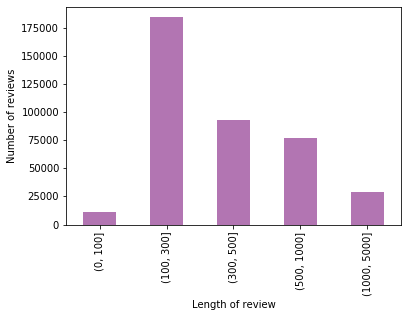

In [31]:
# A bar plot showing that a review is long = alot of sentences. 
# we gauge that a sentence length is ~ 100 
# Hence, we break up reviews into sentences before performing sentiment analysis.

# Adding length of each review to df
df['review_len'] = df['Text'].astype(str).apply(len)

# Plotting a bar graph
bins= [0,100,300,500,1000,5000]
reviews = df.groupby(pd.cut(df['review_len'], bins=bins)).review_len.count()
reviews.plot(kind='bar', color = (0.5,0.1,0.5,0.6))
plt.xlabel('Length of review')
plt.ylabel('Number of reviews')

## 2. Clean the Train Dataset and label with Vader Sentiment Analysis

In [18]:
import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



In [19]:
#Vader testing 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
  
sid_obj = SentimentIntensityAnalyzer() 
# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        return("+") 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        return("-")  
  
    
def sentiment_analyzer_scores(sentence):
    score = sid_obj.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))


In [ ]:
# Clean the training data 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
tokenizer=RegexpTokenizer('\w+|\$[\d\.]+')

# Store the sequence of sentence labels in the following list.
labels = []

# Store the sentences in a corpus
corpus = []

training_file = './training.txt'

train =open(training_file,'r')

# Get only 80000 reviews

count=0

for review in train:

    if count <80000:
        
        review = cleanhtml(review)
        review = decontracted(review)
        
        # Tokenize the reviews and get a list of sentences
        sentences = sent_tokenize(review)
        count+=1
        
        for sentence in sentences:
            #split sentence if theres a dot
            sent = sentence.split('.')
            
            for s in sent:
                #Tokenize the sentences
                words = tokenizer.tokenize(s)

                #if tokenize words not empty, append to corpus
                if words != []:
                    corpus.append(words)
                    
train.close()

In [ ]:
#Labelling our train data set(80000 reviews) using Vader Sentiment Analysis

labelled = open('labelledtraining.txt','w')

for sent in corpus:
    
    # Joining words to form sentence
    sent=' '.join(sent)
    
    #Apply Vader Sentiment Analysis
    score=sentiment_scores(sent)
      
    #positive label
    if score == '+':
        labelled.write('+')
        labelled.write('\t')
        labelled.write(sent)
        labelled.write('\n')

    #negative label
    elif score =='-':
        labelled.write('-')
        labelled.write('\t')
        labelled.write(sent)
        labelled.write('\n')
            
labelled.close()

## 3. Train Naive Bayes Classifier & Test accuracy on manually labelled test data

In [4]:
# NaiveBayes Classifier
import nltk
import gensim

stop_list = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.porter.PorterStemmer()

# The variable below specifies which file is used for training.
# You can modify this variable to use a different file for training.
training_file = './labelledtraining.txt'

# Open the training file.
f = open(training_file, 'r')

# We use the following list to store the sequence of sentence labels.
labels = []

# We use the following list to store the sentences, where each sentence itself is a list of words.
corpus = []
training_data=[]

for line in f:
    # For each line of the input file, extract the label and the text.
    line = line.strip()
    (label, text) = line.split('\t')
    
    # Store the label into the list of labels.
    labels.append(label)
    
    # Tokenize the text.
    sent = nltk.word_tokenize(text)
    
    # Store the sentence into the corpus.
    corpus.append(sent)
    training_data.append(sent)

f.close()

print('Finished reading sentences from the training data file.')

# Create a dictionary from the corpus.
dictionary = gensim.corpora.Dictionary(corpus)

# Store the labeled training data in the following list.
labeled_training_data = []
    
# Going through the two lists in parallel to create the labeled data set.
for (l, s) in zip(labels, corpus):

    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}
    
    # Add the labeled sentence to the labeled data set.
    labeled_training_data.append((sent_as_dict, l))
    
print('Finished preparing the training data.')

# Training a classifier.
# Choose one of the following two classification algorithms to train a classifier.
classifier = nltk.NaiveBayesClassifier.train(labeled_training_data)

print('Finished training the classifier.')

C:\Users\Boon Hwee\Anaconda3\kelly\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Finished reading sentences from the training data file.
Finished preparing the training data.
Finished training the classifier.


In [4]:
#Saving the Naivebayes Classifier to current directory as "naivebayes.pickle". So that we don't have to train it all the time. We can just reuse it.
import pickle
save_classifier = open("naivebayes.pickle","wb") #binary write
pickle.dump(classifier, save_classifier)
save_classifier.close()

#Load the save classifier 
classifier_saved = open("naivebayes.pickle", "rb") #binary read
classifier_load = pickle.load(classifier_saved)
classifier_saved.close()

In [5]:
# Testing the accuracy of Naivebayes classifier on manually labelled test data set.

test_file = './labelledtestmanual100.txt'

# Open the test data file.
f = open(test_file, 'r')

# The following steps are almost the same as the ones for preparing the training data.
labels = []
corpus = []

for line in f:
    line = line.strip()
    (label, text) = line.split('\t')
    labels.append(label)
    sent = nltk.word_tokenize(text)
    corpus.append(sent)
f.close()

print('Finished reading sentences from the test data file.')

# Store the labeled test data in the following list.
labeled_test_data = []
    
# Going through the two lists in parallel to create the labeled data set.
for (l, s) in zip(labels, corpus):

    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}
    
    # Add the labeled sentence to the labeled data set.
    labeled_test_data.append((sent_as_dict, l))
    
print('Finished preparing the test data.')

# Test the accuracy.
print("Accuracy on test data: ", nltk.classify.accuracy(classifier, labeled_test_data))

Finished reading sentences from the test data file.
Finished preparing the test data.
Accuracy on test data:  0.7857142857142857


## 3. Train MaxEnt Classifier & Test accuracy on manually labelled test data


In [ ]:
# Maxent Classifier

#Set iterations and the define classifer
numIterations = 100

algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]

#Train the classifier 
entclassifier = nltk.MaxentClassifier.train(labeled_training_data, algorithm, max_iter=numIterations)

#Print accuracy
print("Accuracy on test data: ", nltk.classify.accuracy(entclassifier, labeled_test_data))

## 4. Predict Labels using Naive Bayes and MaxEnt Classifier on manually labelled test dataset (100 reviews)

In [6]:
# Predict labels using both classifiers on manually labelled test data set.

classifier_saved = open("maxentclassification.pickle", "rb") #binary read
maxentclassifier = pickle.load(classifier_saved)
classifier_saved.close()

classifier_saved = open("naivebayes.pickle", "rb") #binary read
naiveclassifier = pickle.load(classifier_saved)
classifier_saved.close()

test_file = './labelledtestmanual100.txt'

# Open the test data file.
f = open(test_file, 'r')

# The following steps are almost the same as the ones for preparing the training data.
labels = []
corpus = []

for line in f:
    line = line.strip()
    (label, text) = line.split('\t')
    labels.append(label)
    sent = nltk.word_tokenize(text)
    corpus.append(sent)
f.close()

print('Finished reading sentences from the test data file.')

# Store the labeled test data in the following list.

y_pred_maxent1=[]
y_true1=[]
y_pred_naivebayes1=[]

for (l, s) in zip(labels, corpus):
    #append true labels
    y_true1.append(l)
    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}

    y_pred_maxent1.append(maxentclassifier.classify(sent_as_dict))
    y_pred_naivebayes1.append(naiveclassifier.classify(sent_as_dict))
    

Finished reading sentences from the test data file.


In [9]:
# max ent confusion matrix
from sklearn.metrics import classification_report
target_names=['pos', 'neg']

print(classification_report(y_true1, y_pred_maxent1,target_names=target_names,digits=4))

              precision    recall  f1-score   support

         pos     0.7967    1.0000    0.8869       290
         neg     0.0000    0.0000    0.0000        74

    accuracy                         0.7967       364
   macro avg     0.3984    0.5000    0.4434       364
weighted avg     0.6347    0.7967    0.7066       364



In [11]:
# naivebayes confusion matrix
from sklearn.metrics import classification_report
target_names=['pos', 'neg']

print(classification_report(y_true1, y_pred_naivebayes1,target_names=target_names,digits=4))

              precision    recall  f1-score   support

         pos     0.8897    0.8345    0.8612       290
         neg     0.4783    0.5946    0.5301        74

    accuracy                         0.7857       364
   macro avg     0.6840    0.7145    0.6957       364
weighted avg     0.8061    0.7857    0.7939       364



## 5. Predict Labels using Naive Bayes and MaxEnt Classifier on Labelled Test Dataset (20%)

In [12]:
# Clean the test data 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
tokenizer=RegexpTokenizer('\w+|\$[\d\.]+')

# Store the sentences in a corpus
corpus = []

testing_file = './test.txt'

test =open(testing_file,'r')

for review in test:
        
        review = cleanhtml(review)
        review = decontracted(review)
        
        # Tokenize the reviews and get a list of sentences
        sentences = sent_tokenize(review)
        
        for sentence in sentences:
            #split sentence if theres a dot
            sent = sentence.split('.')
            
            for s in sent:
                #Tokenize the sentences
                words = tokenizer.tokenize(s)

                #if tokenize words not empty, append to corpus
                if words != []:
                    corpus.append(words)
                    
test.close()

In [ ]:
#Labelling our test data set using Vader Sentiment Analysis

labelled = open('labelledtest.txt','w')

for sent in corpus:
    
    # Joining words to form sentence
    sent=' '.join(sent)
    
    #Apply Vader Sentiment Analysis
    score=sentiment_scores(sent)
      
    #positive label
    if score == '+':
        labelled.write('+')
        labelled.write('\t')
        labelled.write(sent)
        labelled.write('\n')

    #negative label
    elif score =='-':
        labelled.write('-')
        labelled.write('\t')
        labelled.write(sent)
        labelled.write('\n')
            
labelled.close()

In [5]:
# Predict labels using both classifiers on labelled test data set.
import pickle
import nltk
classifier_saved = open("maxentclassification.pickle", "rb") #binary read
maxentclassifier = pickle.load(classifier_saved)
classifier_saved.close()

classifier_saved = open("naivebayes.pickle", "rb") #binary read
naiveclassifier = pickle.load(classifier_saved)
classifier_saved.close()

test_file = './labelledtest.txt'

# Open the test data file.
f = open(test_file, 'r')

# The following steps are almost the same as the ones for preparing the training data.
labels = []
corpus = []

for line in f:
    line = line.strip()
    (label, text) = line.split('\t')
    labels.append(label)
    sent = nltk.word_tokenize(text)
    corpus.append(sent)
f.close()

print('Finished reading sentences from the test data file.')

# Store the labeled test data in the following list.

y_pred_maxent=[]
y_true=[]
y_pred_naivebayes=[]

for (l, s) in zip(labels, corpus):
    #append true labels
    y_true.append(l)
    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}

    y_pred_maxent.append(maxentclassifier.classify(sent_as_dict))
    y_pred_naivebayes.append(naiveclassifier.classify(sent_as_dict))


Finished reading sentences from the test data file.


In [6]:
# max ent confusion matrix
from sklearn.metrics import classification_report
target_names=['pos', 'neg']

print(classification_report(y_true, y_pred_maxent,target_names=target_names,digits = 4))

              precision    recall  f1-score   support

         pos     0.7944    0.9997    0.8853    244409
         neg     0.9534    0.0200    0.0392     64530

    accuracy                         0.7951    308939
   macro avg     0.8739    0.5099    0.4622    308939
weighted avg     0.8276    0.7951    0.7086    308939



In [7]:
# naivebayes confusion matrix
from sklearn.metrics import classification_report
target_names=['pos', 'neg']

print(classification_report(y_true, y_pred_naivebayes,target_names=target_names, digits = 4 ))

              precision    recall  f1-score   support

         pos     0.9443    0.8616    0.9010    244409
         neg     0.6063    0.8074    0.6926     64530

    accuracy                         0.8503    308939
   macro avg     0.7753    0.8345    0.7968    308939
weighted avg     0.8737    0.8503    0.8575    308939



In [8]:
#confusion matrix 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import scikitplot.metrics as sciplot

print(sciplot.plot_confusion_matrix(y_true ,y_pred_naivebayes))
print(sciplot.plot_confusion_matrix(y_true ,y_pred_maxent))


AxesSubplot(0.125,0.11;0.62x0.77)
AxesSubplot(0.125,0.11;0.62x0.77)


## 6. Evaluation on 10 reviews - Comparing labelled with naive bayes classifier & manually labelled

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
tokenizer=RegexpTokenizer('\w+|\$[\d\.]+')

# Store the sequence of sentence labels in the following list.
labels = []

# Store the sentences in the following list.
corpus = []

test_file = './evaluation10.txt'

f=open(test_file,'r')
# for each review
for review in f:
    #remove <br>
    review = cleanhtml(review)
    review = decontracted(review)
    # Tokenize the reviews 
    sentences = sent_tokenize(review) #list of sentence
    for sentence in sentences:
        #split sentence if theres .
        sent = sentence.split('.')
        for s in sent:
            #Tokenize the sentences
            words = tokenizer.tokenize(s)
            
            #if tokenize words not empty, append to corpus
            if words != []:
                corpus.append(words)
f.close()


predicted_labels = []
f = open('labelledevaluation10.txt','w')
count = 0
for sent in corpus:
    sente=' '.join(sent)
    score=sentiment_scores(sente)
    labels.append(score)
    
for (l, s) in zip(labels, corpus):

    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)

    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}

    # Add the labeled sentence to the labeled data set.
    # labeled_test_data.append((sent_as_dict, l))
    predicted_labels.append(classifier.classify(sent_as_dict))

print(predicted_labels)
for (a,b) in zip(predicted_labels, corpus):
    
    f.write(a)
    f.write('\t')
    f.write(' '.join(b))
    f.write('\n')
    
f.close()

In [9]:
test_file = './labelledevaluation10.txt'
manual_file = './manualevaluation10.txt'
labels=[]
manual=[]
f=open(test_file,'r')
# for each review
for review in f:
    #remove <br>
    (l,s)=review.split('\t')
    labels.append(l)
f.close()

f=open(manual_file,'r')
# for each review
for review in f:
    #remove <br>
    (l,s)=review.split('\t')
    manual.append(l)
f.close()
# print(labels)
# print(manual)
total = len(labels)
correct = 0
for (tl, pl) in zip(labels, manual):
    if tl == pl:
        correct = correct + 1
accu = correct / total
print("File:", f)
print("Accuracy: ", accu)

File: <_io.TextIOWrapper name='./manualevaluation10.txt' mode='r' encoding='cp1252'>
Accuracy:  0.8518518518518519


## 7. Visualisation of our Dataset

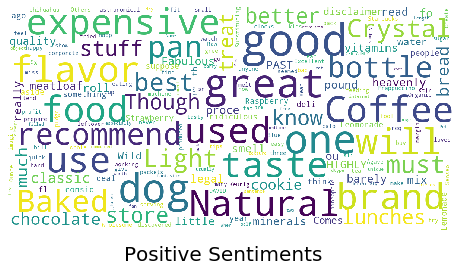

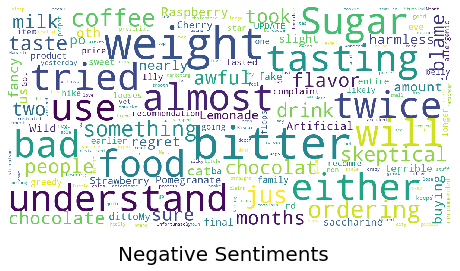

In [45]:
# Wordcloud that shows postive and negative words respectively in our training data set
labelled_data= pd.read_csv('labelledtraining.txt', encoding='latin1', sep = "\t",  header=None)
labelled_data.columns = ['label','sentence']
import matplotlib as mpl

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100            
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(labelled_data["sentence"].loc[labelled_data['label'] == '+'],title = 'Positive Sentiments')
show_wordcloud(labelled_data["sentence"].loc[labelled_data['label'] == '-'],title = 'Negative Sentiments')

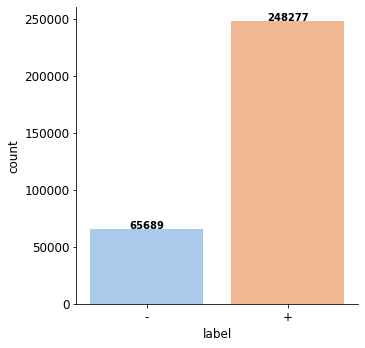

In [47]:
# Plot number of positive and negative sentiments in labelled training dataset
labelled_train_plot = sns.catplot(kind='count', x = 'label', palette="pastel", data = labelled_data)
for i, bar in enumerate(labelled_train_plot.ax.patches):
    h = bar.get_height()
    labelled_train_plot.ax.text(
        i, # bar index (x coordinate of text)
        h+10, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center', 
        fontweight='bold', 
        size=10)

##  8. Incorporating Sentiment Analysis with Clustering

In [21]:
listofquery=["i am so happy. It is delicious. i do not like it","this food is great. this is bad","i strongly recommend"]

In [23]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
tokenizer=RegexpTokenizer('\w+|\$[\d\.]+')
listofquerywithsentiment=[]

for i in listofquery:
    sentences=[]
    listquery=[]
    labels=[]
    pos_score=0
    neg_score=0
    predicted_labels=[]
    thelines=[]
    positive=[]
    negative=[]
    listquery.append(i)
    i = cleanhtml(i)
    i = decontracted(i)
    sentence = sent_tokenize(i)
    for lines in sentence:
        words=lines.split(".")
        for word in words:
            word=tokenizer.tokenize(word)
            if word != []:
                thisline=" ".join(word)
                labels.append(sentiment_scores(thisline))
                sentences.append(word)
    #print(sentences) 
    #print(labels)
    # Going through the two lists in parallel to create the labeled data set.
    for (l, s) in zip(labels, sentences):

        # Convert the original sentence into a vector.
        vector = dictionary.doc2bow(s)

        # Create a dict object to store the document vector (in order to use NLTK's classifier later)
        sent_as_dict = {id:1 for (id, tf) in vector}

        # Add the labeled sentence to the labeled data set.
        # labeled_test_data.append((sent_as_dict, l))
        
        predicted_labels.append(naiveclassifier.classify(sent_as_dict))
    #print(predicted_labels)
    counter=0
    for i in predicted_labels:
        if i =="+":
            pos_score+=1
            positive.append(sentences[counter])
            counter+=1
        elif i =="-":
            neg_score+=1
            negative.append(sentences[counter])
            counter+=1
    #print(pos_score)
    #print(counter)
    #print(positive)
    #print(negative)
    thisreview=[listquery,positive,negative,pos_score,neg_score]
    listofquerywithsentiment.append(thisreview)
#print(listofquerywithsentiment)

for r in listofquerywithsentiment:
    review=r[0]
    positivesentences=r[1]
    negativesentences=r[2]
    positivescore=r[3]
    negativescore=r[4]
    print("This is the review:")
    print(review)
    print("positive score is:")
    print(positivescore)
    if positivesentences!=[]:
        for i in positivesentences:
            print(i)
    print("negative score is:")
    print(negativescore)
    if negativesentences!=[]:
        for i in negativesentences:
            print(i)

This is the review:
['i am so happy. It is delicious. i do not like it']
positive score is:
3
['i', 'am', 'so', 'happy']
['It', 'is', 'delicious']
['i', 'do', 'not', 'like', 'it']
negative score is:
0
This is the review:
['this food is great. this is bad']
positive score is:
1
['this', 'food', 'is', 'great']
negative score is:
1
['this', 'is', 'bad']
This is the review:
['i strongly recommend']
positive score is:
1
['i', 'strongly', 'recommend']
negative score is:
0


## 9. Incorporating Sentiment Analysis for Product Owners to view positive & negative sentiments for a product

In [16]:
# owner will input their product id 
# extract from data set the list of reviews
# show the postive and negative

input_pid = 'B001GVISJM'

product_df = df.loc[df['ProductId'] == input_pid]

product_reviews = list(product_df['Text'])


In [46]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
tokenizer=RegexpTokenizer('\w+|\$[\d\.]+')
listofquerywithsentiment=[]

for i in product_reviews:
    sentences=[]
    listquery=[]
    labels=[]
    pos_score=0
    neg_score=0
    predicted_labels=[]
    thelines=[]
    positive=[]
    negative=[]
    listquery.append(i)
    i = cleanhtml(i)
    i = decontracted(i)
    sentence = sent_tokenize(i)
    for lines in sentence:
        words=lines.split(".")
        for word in words:
            word=tokenizer.tokenize(word)
            if word != []:
                thisline=" ".join(word)
                labels.append(sentiment_scores(thisline))
                sentences.append(word)
    #print(sentences) 
    #print(labels)
    # Going through the two lists in parallel to create the labeled data set.
    for (l, s) in zip(labels, sentences):

        # Convert the original sentence into a vector.
        vector = dictionary.doc2bow(s)

        # Create a dict object to store the document vector (in order to use NLTK's classifier later)
        sent_as_dict = {id:1 for (id, tf) in vector}

        # Add the labeled sentence to the labeled data set.
        # labeled_test_data.append((sent_as_dict, l))
        
        predicted_labels.append(classifier.classify(sent_as_dict))
    #print(predicted_labels)
    counter=0
    for i in predicted_labels:
        if i =="+":
            pos_score+=1
            positive.append(sentences[counter])
            counter+=1
        elif i =="-":
            neg_score+=1
            negative.append(sentences[counter])
            counter+=1
    #print(pos_score)
    #print(counter)
    #print(positive)
    #print(negative)
    thisreview=[listquery,positive,negative,pos_score,neg_score]
    listofquerywithsentiment.append(thisreview)
#print(listofquerywithsentiment)
count = 1
for r in listofquerywithsentiment:
    review=r[0]
    positivesentences=r[1]
    negativesentences=r[2]
    positivescore=r[3]
    negativescore=r[4]
    print("Review #", count, ":")
    count += 1
    print(review)
    print("positive score is:")
    print(positivescore)
    if positivesentences!=[]:
        for i in positivesentences:
            print(i)
    print("negative score is:")
    print(negativescore)
    if negativesentences!=[]:
        for i in negativesentences:
            print(i)
    print()

Review # 1 :
['good flavor! these came securely packed... they were fresh and delicious! i love these Twizzlers!']
positive score is:
4
['good', 'flavor']
['these', 'came', 'securely', 'packed']
['they', 'were', 'fresh', 'and', 'delicious']
['i', 'love', 'these', 'Twizzlers']
negative score is:
0

Review # 2 :
['The Strawberry Twizzlers are my guilty pleasure - yummy. Six pounds will be around for a while with my son and I.']
positive score is:
2
['The', 'Strawberry', 'Twizzlers', 'are', 'my', 'guilty', 'pleasure', 'yummy']
['Six', 'pounds', 'will', 'be', 'around', 'for', 'a', 'while', 'with', 'my', 'son', 'and', 'I']
negative score is:
0

Review # 3 :
["My daughter loves twizzlers and this shipment of six pounds really hit the spot. It's exactly what you would expect...six packages of strawberry twizzlers."]
positive score is:
3
['My', 'daughter', 'loves', 'twizzlers', 'and', 'this', 'shipment', 'of', 'six', 'pounds', 'really', 'hit', 'the', 'spot']
['It', 'is', 'exactly', 'what', 'yo